# Local level state space model with Kalman Filter

For references check
- Bayesian Inference of State Space Models: Kalman Filtering and Beyond (Kostas Triantafyllopoulos) 

The model has the following form:

yt = xt.T·bt + et | et~N(0,v)

bt = Ft·bt-1 + mt | mt~N(0,Z)

In [39]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm
import matplotlib.pyplot as plt
import numpy as np

## Test data

In [99]:
# Model specification
T = 500

params_e = (0,.2)
params_m = (np.array([0,0]),np.array([[1,0],[0,.3]]))
params_b0 = (np.array([10,20]),np.array([[2,1],[1,4]]))
F = np.array([[1,0],[0,1]])

x = np.full([2,T],1)

In [100]:
def generate_data(T,x,F,params_e,params_m,params_b0):
    b = np.full([2,T],np.nan)
    y = np.full(T,np.nan)
    e = np.full(T,np.nan)
    m = np.full([2,T],np.nan)

    b[:,0] = mnorm.rvs(*params_b0)
    y[0] = x[:,0]@b[:,0] + norm.rvs(*params_e)

    for t in range(1,T):
        b[:,t] = F@b[:,t-1] + mnorm.rvs(*params_m)
        y[t] = x[:,t]@b[:,t] + norm.rvs(*params_e)
    return y,b

y_real,b_real = generate_data(T,x,F,params_e,params_m,params_b0)

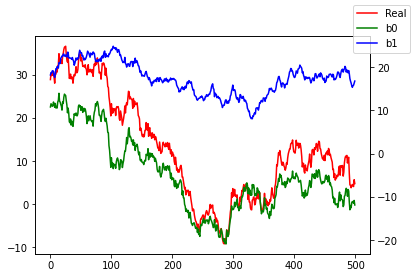

In [150]:
def plot_data(y,b):
    fig,ax = plt.subplots()
    ax.plot(y,c="r")
    ax2 = ax.twinx()
    ax2.plot(b[0],c="g")
    ax2.plot(b[1],c="b")
    fig.legend(["Real", "b0", "b1"])
    fig.show()
plot_data(y_real,b_real)

## Kalman Filter

In [191]:
def forecast_b(b_posterior_tme1,P_posterior_tme1,Ft,params_m):
    b_prior_t = Ft@b_posterior_tme1
    P_prior_t = Ft@P_posterior_tme1@Ft + params_m[1]**2
    return b_prior_t,P_prior_t

def filter_step(b_prior_t,P_prior_t,xt,yt,params_e):
    y_prior_t = xt@b_prior_t
    et = yt-y_prior_t
    q_prior_t = xt@P_prior_t@xt + params_e[1]**2
    Kt = P_prior_t@xt/q_prior_t
    P_posterior_t = P_prior_t - q_prior_t*Kt@Kt.T
    b_posterior_t = b_prior_t + Kt*et
    return b_posterior_t,P_posterior_t

def filter(y,x,F,params_e,params_m,params_b0):
    T = y.shape[0]
    
    b_prior = np.full([2,T],np.nan)
    b_posterior = np.full([2,T],np.nan)
    P_prior = np.full([2,2,T],np.nan)
    P_posterior = np.full([2,2,T],np.nan)

    b_prior[:,0],P_prior[:,:,0] = params_b0[0],params_m[1]
    # b_prior[:,0],P_prior[:,:,0] = params_b0[0],params_b0[1]
    b_posterior[:,0],P_posterior[:,:,0] = filter_step(b_prior[:,0],P_prior[:,:,0],x[:,0],y[0],params_e)

    for t in range(1,T):
        b_prior[:,t],P_prior[:,:,t] = forecast_b(b_posterior[:,t-1],P_posterior[:,:,t-1],F,params_m)
        b_posterior[:,t],P_posterior[:,:,t] = filter_step(b_prior[:,t],P_prior[:,:,t],x[:,t],y[t],params_e)
    
    return b_posterior, P_posterior, b_prior, P_prior

b_posterior, P_posterior, b_prior, P_prior = filter(y_real,x,F,params_e, params_m, params_b0)

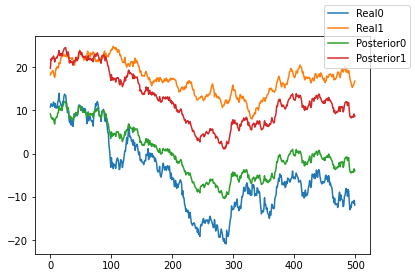

In [192]:
fig,ax = plt.subplots()
ax.plot(b_real[0,:])
ax.plot(b_real[1,:])
ax.plot(b_posterior[0,:])
ax.plot(b_posterior[1,:])

# i = 1
# ax.plot(b_posterior[i,:])
# ax.plot(b_real[i,:])
# devs = np.full([2,b_posterior.shape[1]],np.nan)
# for t in range(T): devs[:,t] = np.array([P_posterior[0,0,t],P_posterior[1,1,t]])
# ax.fill_between(x = np.arange(b_posterior.shape[1]), y1 = b_posterior[i,:]+devs[i,:], y2 = b_posterior[i,:]-devs[i,:])
# fig.legend(["Posterior","Real","1std"])
fig.legend(["Real0","Real1","Posterior0","Posterior1"])
fig.show()

In [142]:
from filterpy.kalman import KalmanFilter

In [148]:
f = KalmanFilter(dim_x=2, dim_z=1)
# f.x = mnorm.rvs(*params_b0)
f.F = F
f.H = np.array([[1,1]])
f.R = params_e[1]
f.P = params_m[1]
f.x[:,0] = params_b0[0]

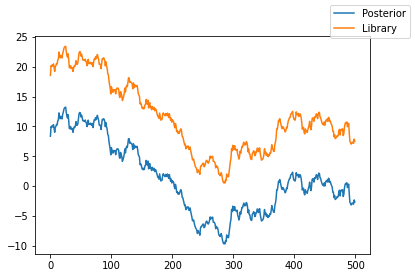

In [193]:
b_posterior_l = np.full([2,y_real.shape[0]],np.nan)
i = 0
for yi in y_real:
    f.predict()
    f.update(yi)
    b_posterior_l[:,i] = f.x[:,0]
    i+=1

fig,ax = plt.subplots()
ax.plot(b_posterior_l[0,:])
ax.plot(b_posterior_l[1,:])

# i = 0
# ax.plot(b_posterior[i,:])
# ax.plot(b_posterior_l[i,:])
# ax.plot(b_real[i,:])
fig.legend(["Posterior","Library","Real"])
fig.show()

In [194]:
def smooth_step(yt,xt,b_prior_t,P_prior_t,b_smooth_tma1,P_smooth_tma1,Ftma1,Ft,params_e,params_m):
    b_posterior_t,P_posterior_t = filter_step(b_prior_t,P_prior_t,xt,yt,params_e)
    b_prior_tma1,P_prior_tma1 = forecast_b(b_posterior_t,P_posterior_t,Ft,params_m)
    Lt = P_posterior_t@Ftma1.T@np.linalg.inv(P_prior_tma1)
    b_smooth_t = b_posterior_t + Lt@(b_smooth_tma1 - b_prior_tma1)
    P_smooth_t = P_posterior_t + Lt@(P_smooth_tma1 - P_prior_tma1)@Lt.T
    y_smooth_t = xt.T@b_smooth_t
    q_smooth_t = xt.T@P_smooth_t@xt + params_e[1]
    # print(y_smooth_t, q_smooth_t, b_smooth_t, P_smooth_t)
    return y_smooth_t, q_smooth_t, b_smooth_t, P_smooth_t

def smooth(y_real,x,F,params_e, params_m, params_b0):
    T = y_real.shape[0]
    b_posterior, P_posterior, b_prior, P_prior = filter(y_real,x,F,params_e, params_m, params_b0)
       
    b_smooth = np.full([2,T],np.nan)
    P_smooth = np.full([2,2,T],np.nan)
    y_smooth = np.full(T,np.nan)
    q_smooth = np.full(T,np.nan)

    b_smooth[:,-1] = b_posterior[:,-1]
    P_smooth[:,:,-1] = P_posterior[:,:,-1]

    for t in range(T-2,-1,-1):
        y_smooth[t],q_smooth[t],b_smooth[:,t],P_smooth[:,:,t] =  smooth_step(y_real[t],x[:,t],b_prior[:,t],P_prior[:,:,t],b_smooth[:,t+1],P_smooth[:,:,t+1],F,F,params_e,params_m)
    
    return y_smooth, q_smooth, b_smooth, P_smooth
y_smooth, q_smooth, b_smooth, P_smooth = smooth(y_real,x,F,params_e, params_m, params_b0)


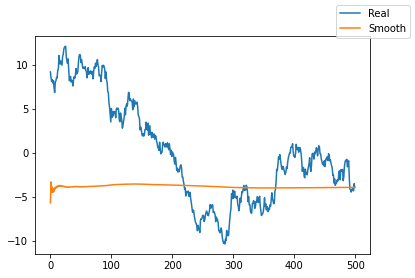

In [195]:
fig,ax = plt.subplots()
ax.plot(b_posterior[0,:])
ax.plot(b_smooth[0,:])
fig.legend(["Real","Smooth"])
fig.show()

In [182]:
np.array([1,2])**2

array([1, 4])